In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array
from models.autoencoder import Autoencoder
from loss.loss import unsupervised_loss, h_loss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Generate 'u' data using the FEM solver

In [9]:
def generate_and_save_fem_u_dataset(f_values, input_shape, file_name):
    a, b, k, M = 0, 1, 1, 255
    c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
    M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)
    u_dataset = []

    for f_value in tqdm(f_values, desc="Generating FEM solutions"):
        f = lambda x: np.full(x.shape[0], f_value)
        u_D = lambda x: x[:, 0] * 0
        fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
        fem_u_reshaped = fem_u.reshape(input_shape)
        u_dataset.append(fem_u_reshaped)

    u_dataset = np.array(u_dataset)
    np.save(file_name, u_dataset)
    print(f"Saved {len(u_dataset)} u matrices to {file_name}")
    return u_dataset

In [10]:
f_values = np.arange(-2000, 2000, 3)
input_shape = (256, 256)
file_name = './u_dataset.npy'
u_dataset = generate_and_save_fem_u_dataset(f_values, input_shape, file_name)
print(f"Generated {len(u_dataset)} u matrices from FEM")

Generating FEM solutions:  22%|██▏       | 175/800 [02:36<09:18,  1.12it/s]


KeyboardInterrupt: 

# VAE Model

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 512)
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [5]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_values = np.load('fem_u_values.npy')

dataset = PoissonDataset(u_values)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
print(u_values)

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.         -0.05229798 -0.09586136 ... -0.09586136 -0.05229798
    0.        ]
  [ 0.         -0.09586136 -0.18052506 ... -0.18052506 -0.09586136
    0.        ]
  ...
  [ 0.         -0.09586136 -0.18052506 ... -0.18052506 -0.09586136
    0.        ]
  [ 0.         -0.05229798 -0.09586136 ... -0.09586136 -0.05229798
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.         -0.05203649 -0.09538205 ... -0.09538205 -0.05203649
    0.        ]
  [ 0.         -0.09538205 -0.17962243 ... -0.17962243 -0.09538205
    0.        ]
  ...
  [ 0.         -0.09538205 -0.17962243 ... -0.17962243 -0.09538205
    0.        ]
  [ 0.         -0.05203649 -0.09538205 ... -0.09538205 -0.05203649
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.  

  2%|▏         | 1/50 [00:00<00:21,  2.24it/s]

Loss: 47666736894327665846518808576.0000


  4%|▍         | 2/50 [00:00<00:21,  2.27it/s]

Loss: 344993663483801931014891110400.0000


  6%|▌         | 3/50 [00:01<00:20,  2.27it/s]

Loss: 7912173134484482386318155841536.0000


  8%|▊         | 4/50 [00:01<00:20,  2.28it/s]

Loss: 145217170971844239393457963008.0000


 10%|█         | 5/50 [00:02<00:19,  2.28it/s]

Loss: 18438641730679366658079397511168.0000


 12%|█▏        | 6/50 [00:02<00:19,  2.28it/s]

Loss: 8690588784440504974858780672.0000


 14%|█▍        | 7/50 [00:03<00:18,  2.29it/s]

Loss: 9410827144759703352771776348160.0000


 16%|█▌        | 8/50 [00:03<00:18,  2.30it/s]

Loss: 655987745324424565187799941120.0000


 18%|█▊        | 9/50 [00:03<00:17,  2.28it/s]

Loss: 1094488963524809292984887541760.0000


 20%|██        | 10/50 [00:04<00:17,  2.28it/s]

Loss: 35856216894289385703191085056.0000


 22%|██▏       | 11/50 [00:04<00:17,  2.28it/s]

Loss: 96563196176973608262383435776.0000


 24%|██▍       | 12/50 [00:05<00:16,  2.28it/s]

Loss: nan


 26%|██▌       | 13/50 [00:05<00:16,  2.28it/s]

Loss: nan


 28%|██▊       | 14/50 [00:06<00:15,  2.29it/s]

Loss: nan


 30%|███       | 15/50 [00:06<00:15,  2.29it/s]

Loss: nan


 32%|███▏      | 16/50 [00:07<00:15,  2.20it/s]

Loss: nan


 34%|███▍      | 17/50 [00:07<00:14,  2.22it/s]

Loss: nan


 36%|███▌      | 18/50 [00:07<00:14,  2.24it/s]

Loss: nan


 38%|███▊      | 19/50 [00:08<00:13,  2.26it/s]

Loss: nan


 40%|████      | 20/50 [00:08<00:13,  2.27it/s]

Loss: nan


 42%|████▏     | 21/50 [00:09<00:12,  2.27it/s]

Loss: nan


 44%|████▍     | 22/50 [00:09<00:12,  2.28it/s]

Loss: nan


 46%|████▌     | 23/50 [00:10<00:11,  2.29it/s]

Loss: nan


 48%|████▊     | 24/50 [00:10<00:11,  2.29it/s]

Loss: nan


 50%|█████     | 25/50 [00:10<00:10,  2.29it/s]

Loss: nan


 52%|█████▏    | 26/50 [00:11<00:10,  2.29it/s]

Loss: nan


 54%|█████▍    | 27/50 [00:11<00:10,  2.29it/s]

Loss: nan


 56%|█████▌    | 28/50 [00:12<00:09,  2.29it/s]

Loss: nan


 58%|█████▊    | 29/50 [00:12<00:09,  2.30it/s]

Loss: nan


 60%|██████    | 30/50 [00:13<00:08,  2.29it/s]

Loss: nan


 62%|██████▏   | 31/50 [00:13<00:08,  2.19it/s]

Loss: nan


 64%|██████▍   | 32/50 [00:14<00:08,  2.21it/s]

Loss: nan


 66%|██████▌   | 33/50 [00:14<00:07,  2.23it/s]

Loss: nan


 68%|██████▊   | 34/50 [00:15<00:07,  2.24it/s]

Loss: nan


 70%|███████   | 35/50 [00:15<00:06,  2.25it/s]

Loss: nan


 72%|███████▏  | 36/50 [00:15<00:06,  2.26it/s]

Loss: nan


 74%|███████▍  | 37/50 [00:16<00:05,  2.26it/s]

Loss: nan


 76%|███████▌  | 38/50 [00:16<00:05,  2.27it/s]

Loss: nan


 78%|███████▊  | 39/50 [00:17<00:04,  2.27it/s]

Loss: nan


 80%|████████  | 40/50 [00:17<00:04,  2.27it/s]

Loss: nan


 82%|████████▏ | 41/50 [00:18<00:03,  2.27it/s]

Loss: nan


 84%|████████▍ | 42/50 [00:18<00:03,  2.28it/s]

Loss: nan


 86%|████████▌ | 43/50 [00:18<00:03,  2.28it/s]

Loss: nan


 88%|████████▊ | 44/50 [00:19<00:02,  2.29it/s]

Loss: nan


 90%|█████████ | 45/50 [00:19<00:02,  2.28it/s]

Loss: nan


 92%|█████████▏| 46/50 [00:20<00:01,  2.28it/s]

Loss: nan


 94%|█████████▍| 47/50 [00:20<00:01,  2.28it/s]

Loss: nan


 96%|█████████▌| 48/50 [00:21<00:00,  2.28it/s]

Loss: nan


 98%|█████████▊| 49/50 [00:21<00:00,  2.27it/s]

Loss: nan


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]

Loss: nan


Last Loss: nan Last vae_model saved to last_vae_model.pth
Best Loss: 8690588784440504974858780672.0000 Best vae_model saved to best_vae_model.pth


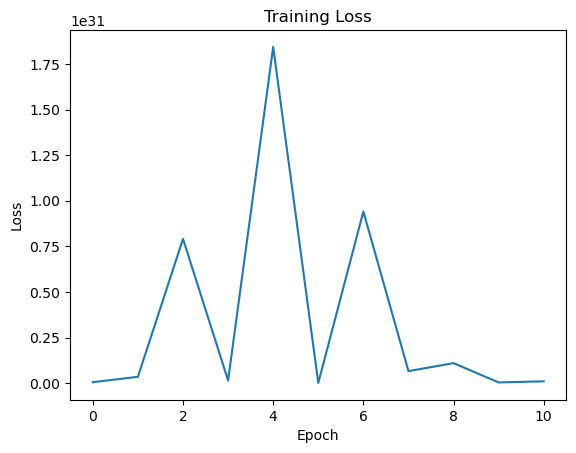

In [7]:
vae_model = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

num_epochs = 50
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    vae_model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae_model(inputs)
        loss = vae_loss(recon_x, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss:.4f}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = vae_model.state_dict()

torch.save(vae_model.state_dict(), 'last_vae_model.pth')
torch.save(best_model_wts, 'best_vae_model.pth')

print(f'Last Loss: {train_loss:.4f} Last vae_model saved to last_vae_model.pth')
print(f'Best Loss: {best_loss:.4f} Best vae_model saved to best_vae_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Latent Space Regression Model

In [ ]:
class LatentRegressionModel(nn.Module):
    def __init__(self, input_dim=1, latent_dim=128):
        super(LatentRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class LatentDataset(Dataset):
    def __init__(self, f_values, latent_vectors):
        self.f_values = f_values
        self.latent_vectors = latent_vectors

    def __len__(self):
        return len(self.f_values)

    def __getitem__(self, idx):
        f_value = self.f_values[idx]
        latent_vector = self.latent_vectors[idx]
        f_tensor = torch.tensor(f_value).float().unsqueeze(0)  # (1,) 형태로 변환
        latent_tensor = torch.tensor(latent_vector).float()
        return f_tensor, latent_tensor

In [ ]:
vae_model = VAE(latent_dim=128).to(device)
vae_model.load_state_dict(torch.load('vae_model.pth'))
vae_model.eval()

In [ ]:
latent_vectors = []
with torch.no_grad():
    for data in train_loader:
        inputs = data.to(device)
        _, mu, _ = vae_model.encode(inputs)
        latent_vectors.append(mu.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)

In [ ]:
latent_dataset = LatentDataset(f_values, latent_vectors)
latent_loader = DataLoader(latent_dataset, batch_size=32, shuffle=True)

latent_model = LatentRegressionModel(input_dim=1, latent_dim=128).to(device)
optimizer = optim.Adam(latent_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    latent_model.train()
    train_loss = 0
    for f, latent in latent_loader:
        f, latent = f.to(device), latent.to(device)
        optimizer.zero_grad()
        latent_pred = latent_model(f)
        loss = criterion(latent_pred, latent)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = latent_model.state_dict()

torch.save(latent_model.state_dict(), 'last_latent_model.pth')
torch.save(best_model_wts, 'best_latent_model.pth')

print(f'Last Loss: {train_loss:.4f} Last latent_model saved to last_latent_model.pth')
print(f'Best Loss: {best_loss:.4f} Best latent_model saved to best_latent_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Inference Model

In [ ]:
vae_model = VAE(latent_dim=128).to(device)
vae_model.load_state_dict(torch.load('vae_model.pth'))
vae_model.eval()

latent_model = LatentRegressionModel(input_dim=1, latent_dim=128).to(device)
latent_model.load_state_dict(torch.load('latent_model.pth'))
latent_model.eval()

test_f_values = np.array([10, 20, 30])  # 테스트할 f 값들

for f in test_f_values:
    f_tensor = torch.tensor(f).float().unsqueeze(0).unsqueeze(0).to(device)  # (1, 1) 형태로 변환
    with torch.no_grad():
        latent_pred = latent_model(f_tensor)
        u_pred = vae_model.decode(latent_pred)
    
    u_pred = u_pred.squeeze().cpu().numpy()
    
    plt.imshow(u_pred, cmap='viridis', extent=(0, 1, 0, 1))
    plt.title(f"Predicted u for f={f}")
    plt.colorbar()
    plt.show()